In [6]:
import sys

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install graphviz

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [27]:
# wraps a value
class Value:
    # `()` is an empty tuple
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # derivative of L with respect to this value
        # 0 means "no effect" (gradient 0)
        self.grad = 0.0
        # default to nothing, on a leaf node there is nothing to do
        self._backward = lambda: None
        self._prev = set(_children) # set is cheaper than tuple
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # we could implement `__exp__` instead... but want to show here
    # that we can build functiond at arbitrary places in the complexity
    # stack
    # !! AS LONG AS WE KNOW THE LOCAL DERIVATIVE !!
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # each node only adds itself to the list
                # after all of its children have been processed
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
# lets write out a neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights / synaptic strengths for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # no activation function for now

o = n.tanh(); o.label = 'o' # output
(n,o)

# example outcomes
# bias 6.0: n = 0.0, o = 0.0 
# bias 6.1: n = 0.1, o = 0.0997
# bias 6.7: n = 0.7, o = 0.6044
# bias 8.0: n = 2.0, o = 0.9640 => squashed!
# bias 10.0: n = 4.0, o = 0.9993
# bias 100.0: n = 94.0, o = 1.0000 (rounded)

(Value(data=0.8813735870195432), Value(data=0.7071067811865476))

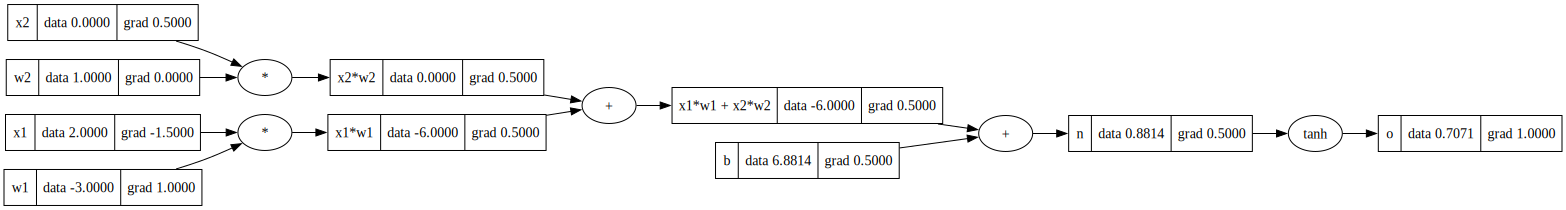

In [26]:
o.backward()
draw_dot(o)

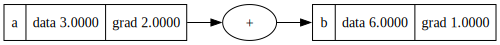

In [24]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

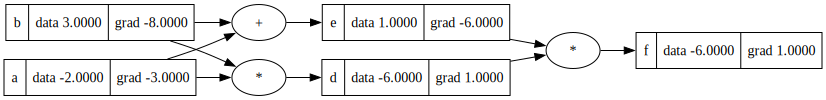

In [23]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)